In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: K-Nearest-Neighbors


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

We already have encountered KNN during the first lectures, when introducing model performance and model selection. Here, we are going to give a closer look to the algorithm, as well as to different ways to calculate distances, and to techniques to speed up the neighbors search.

Students are assumed to have followed the class and understood the following concepts: 
* lazy learning
* distance functions 
* KD-trees and ball-tress
* Curse of Dimensionality

With this notebook, we will review the following concepts: 
1. KNN: Introduction
1. Distance Functions 
1. KNN Algorithm
  * Classification 
  * Regression 
  * Varying $k$
1. Speeding up Knn
  * KD-Trees
  * Ball Trees 
1. The Curse of Dimensionality 
1. Other Remarks 
1. Examples in Python 
  * Classification 
  * Regression 
1. Example on the Heart Data 


## 1. KNN: Introduction
KNN is a *non-parametric* algorithm with a peculiarity that distinguishes it from all other DM models we have encountered so far: it doesn't need to be trained. This is because predictions of KNN are made simply by "copying" the class of the data points that are closest to the ones we want to predict (hence its name). This type of learning - where no model is learned- is called **lazy learning** in the Machine Learning community. Furthermore, because predictions are based on other observed data rather than an underlying model, the way KNN performs prediction is also called **instance-based** learning. 

As you may recall from the introduction of KNN given in the beginning of the course, KNN works by evaluating the location of the test point we want to predict (indicated with a $^*$ in the plot below), and takes its $k$ ($\in \mathbb{N}^+$) closest neighbors ($k=3$ in the next plot), and performs prediction. 

<img src="./img/knn/example.png" width="650" height="50"/>

Therefore, the algorithm chooses the training points that are closest to the new example we want to predict, and predicts the most common class among such points. How the closest points are chosen requires a definition of distance, which we are going to provide now. 


## 2. Distance Functions 
The most common distance function used for KNN is the **Euclidean distance**. It is called like this because it measures the $l_2$ (Euclidean) norm of the difference between two vectors $\mathbf{x}$ and $\mathbf{z}$: 

<br>
$$d(\mathbf{x}, \mathbf{z}) = ||\mathbf{x}-\mathbf{z}||_2 =  \sqrt{(x_1-z_1)^2 + (x_2-z_2)^2 + \cdots + (x_D-z_D)^2}$$
<br>

with $\mathbf{x},\mathbf{z}\ \in\ \mathbb{R}^D$. 
<br>

Another common distance function is the **Manatthan distance**, also called *city-block* distance (the name is due to the fact that this is the distance a car would travel from one point to another in a city arranged in square blocks). This distance is the $l_1$ norm of the difference between $\mathbf{x}$ and $\mathbf{z}$: 

<br>
$$d(\mathbf{x}, \mathbf{z}) = ||\mathbf{x}-\mathbf{z}||_1 =  \left(|x_1-z_1| + |x_2-z_2| + \cdots + |x_D-z_D|\right)$$
<br>

Further information on the $l_1$ distance can be found on [Wikipedia](https://en.wikipedia.org/wiki/Taxicab_geometry). 

Both the Euclidean and the Manatthan distances are special cases of the **Minkowski distance**, defined as the $l_p$ norm of the difference of two vectors: 

$$ d(\mathbf{x}, \mathbf{z}) = ||\mathbf{x}-\mathbf{z}||_p = \left(|x_1-z_1|^p + |x_2-z_2|^p + \cdots + |x_D-z_D|^p\right)^{\frac{1}{p}}.$$

When $p=1$, this is equivalent to the Manatthan distance, and with $p=2$, this is equivalent to the Euclidean distance. As we increase $p$, we give more and more weight to the dimensions having larger differences. With $p=\infty$ we have the *Chebyshev distance*, which is equal to 

<br>
$$d(\mathbf{x},\mathbf{z}) = \max_d |x_d-z_d|,\ d=1,...,D$$. 
<br>

The following figure plots all the point having distance 1 from an arbitrary point in a two-dimensional space detected by the Euclidean, Manatthan, and Minkowski with p=4 distances.


<img src="./img/knn/distances.png" width="350" height="50"/>


If the $d$-th dimension of $\mathbf{x}$ and $\mathbf{z}$ is categorical, rather than continuous, we simply denote the distance of two categories as: 

$$
d(x_d, y_d) = 
\left\{
\begin{array}{rl}
1 & \ if\ x_d \neq y_d \\
0 & \ if\  x_d = y_d
\end{array}
\right.
$$

Note that this definition of distance is automatically implemented if categorical features are one-hot encoded. 


## 3. KNN Algorithm 
### 3.1 Classification
Given a new point $\mathbf{x}^*$ that we wish to classify, a value for $k$, and a distance function, KNN finds the set $S_{\mathbf{x}^*}$ of the $k$ closest training points to $\mathbf{x}^*$. $S_{\mathbf{x}^*}$ is called the *neighborhood* of $\mathbf{x}^*$; by "closest points", it is meant the $k$ training observation that have the minimum distance from $\mathbf{x}^*$. Subsequently, the probability of each class $y=c$ is calculated within the neighborhood: 

<br>
$$ p_c = \frac{\sum_{i \in S_{\mathbf{x}^*}} \mathcal{I}(y_i=c) }{\sum_{i=1}^{n} \mathcal{I}(\mathbf{x}_i \in S_{\mathbf{x}^*})} = \frac{\#\ of\ instances\ in\ the\ neighborhood\ belonging\ to\ class\ c}{total\ \#\ of\ instances\ in\ the\ neighborhood} $$
<br>

The point $\mathbf{x}^*$ is then predicted to the class $c$ that maximizes $p_c$. 


**Example**. We shall see a small example (using Euclidean distance) with $n=5$ data points, and $p=2$ features (do not confuse the $p$ to denote the number of features with the $p$ used to indicate the order of the Minkowski distance), and a point that we need to predict. The dataset is the following one: 


|| $$\mathbf{X}_1$$ | $$\mathbf{X}_2$$ | Class | 
|:----:|:---:|:---:|:---:|
| 1 | 0.1 | 0.1 | 1 | 
| 2 | 0.3 | 0.45 | 1 | 
| 3 | 0.35 | 0.6 | 1 | 
| 4 | 0.55 | 0.6 | 2 | 
| 5 | 0.9 | 0.15 | 2 | 
|**6** | **0.5** | **0.5**| **?**|

Unit 6 is the one we need to predict. Graphically, the data appears as follows: 

<img src="./img/knn/algorithm_example.png" width="350" height="50"/>


The Euclidean distance of point 6 from the first training point is: 

$$d(1,6) = \sqrt{(0.1-0.5)^2+(0.1-0.5)^2} = 0.566$$

Repeating the calculation for all the examples in the training set we obtain: 

$$d(1,6) = 0.566$$
$$d(2,6) = 0.206$$
$$d(3,6) = 0.180$$
$$d(4,6) = 0.112$$
$$d(5,6) = 0.532$$

With $k=1$, we would choose unit number 4 as the candidate neighbor, and we would predict the class of such unit for the new example, which happens to be Class 2. 

<img src="./img/knn/algorithm_example_k1.png" width="350" height="50"/>


However, with different values of $k$ it is not sure that we would predict the same class. For example, with $k=3$, the neighborhood of point 6 is composed by points 2, 3, and 4. In this case, the class with maximum probability is class 1, with $p_{Class\ 1} = 2/3$. In this case, point 6 is predicted to belong to class 1. 

<img src="./img/knn/algorithm_example_k3.png" width="350" height="50"/>


### 3.2 Regression
In regression the KNN algorithm works in the same way as the classification case. The only difference is that, since now we have a continuous rather than categorical output, we predict $y^*$ with the *average* of the output in the neighborhood $S_{\mathbf{x}^*}$: 

$$ y^* = \frac{\sum_{i \in S_{\mathbf{x}^*}} y_i}{\sum_{i=1}^{n} \mathcal{I}(\mathbf{x}_i \in S_{\mathbf{x}^*})} $$


### 3.3 Varying k
Increasing the number of neighbors $k$ has the effect of decreasing model complexity; this is due to the fact that predictions become function of a larger number of points and, therefore, less dependent on specific data points of the training set. This results in a smoother decision boundary in a classification, and in a smoother prediction function in regression. Decreasing $k$, of course, has the opposite effect. For the bias-variance tradeoff, when KNN is overfitting, increasing $k$ has the effect of decreasing the variance of the predictions; when KNN is underfitting, decreasing $k$ has the effect of decreasing the bias of the predictions.   

We see in the following plots the effect of varying $k$ on a regression function (with $p=1$ feature) above; and the effect on classification boundaries ($p=2$ features) below. 

<img src="./img/knn/varying_k.png" width="800" height="50"/>



Look at the picture, and answer the following quesions: Where do you expect higher training error, and where a lower one? Where do you expect higher test error, and were a lower one? 


## 4. Speeding Up KNN
For each new example we need to predict, the KNN algorithm presented above needs to compute a distance function for all the points in the training dataset, which takes $\mathcal{O}(pn)$ operations. This means that for $m$ new points that need to be predicted, the prediction time take $\mathcal{O}(mpn)$ operations: this version of KNN is also called *brute-force* method, as all training points are repeatedly checked. It results clear, then, that in large datasets the computational performance of KNN gets dramatically slow. 

For this reason, methods have been devised that pre-process the data by storing them in form of *tree data structures* (a bit similar to the structure created by decision trees, but conceptually different). If the created trees are well balanced, prediction time can get as low as $\mathcal{O}(mp\ log_2n)$ operations. The two most common tree structures for KNN are known as *KD-trees* and *Ball-trees*. 

**KD-trees**. KD-trees start by considering the whole sampling space, and perform splits at the medium point of the dimension with highest variability (for example, the mean or median points of the feature with largest variance). The process is repeated recursively, and it can be stopped when all units end up in their own leaf (but not necessarily: it can also end when a predetermined number of leaves has been reached). At this point, performing a prediction is just a matter of descending the units we want to predict down the branches of the tree, towards the region the point belongs to (which is a $\mathcal{O}(log_2(n))$ operation for a fully grown balanced tree, as we have seen with decision trees). The point lying in the resulting node is a candidate nearest-neighbor; to check whether closer neighbors exist, we can explore the node's siblings, its parent, and so on and so forth, until there are no more potential nodes that are closer to the candidate one (otherwise, you should just update the candidate point). If the tree is well-balanced, the computational time of KD-trees represents a considerable increase of speed w.r.t. the brute-force method. You can find more information about KD-trees on the corresponding [Wikipedia page](https://en.wikipedia.org/wiki/K-d_tree). 

The next figure, taken and re-adapted from the book ["Data Mining" by Witten et. al](https://www.cs.waikato.ac.nz/ml/weka/book.html), shows a toy example of how KD-trees split the data region, and how the corresponding KD-tree is built. 

<img src="./img/knn/kd_tree.png" width="650" height="50"/>



**Ball-trees**. KD-trees work well in a moderate number of dimensions (not more than 20 or 30), but they start to perform poorly as the number of dimensions increases. The reason is that in high dimensions the trees are not able to reduce sufficiently the distance between points, and exhaustive search across several nodes (data points) must be performed. An improvement of KD-trees is given by ball trees, which splits the data space into hyper-spherical, rather than hyper-rectangular, regions. Because of this simple modification, Ball-trees can become more efficient than KD-trees, as they allow to better separate the nodes and identify the correct region of new points, by using information about center and radius of each hyper-sphere. Creating splits and new nodes for a ball-tree data structure requires clustering units into the (sub-)regions centers, and calculating the minimum radius necessary to enclose all units. Building a Ball-tree is computationally slower than building a KD-tree, but it gains performance during the prediction stage in high dimensions. However, as the number of dimensions become larger, also Ball-trees loose performance computationally. More information can be found in the [Wikipedia page](https://en.wikipedia.org/wiki/Ball_tree#Nearest-neighbor_search). 

This figure, also taken from ["Data Mining"](https://www.cs.waikato.ac.nz/ml/weka/book.html), shows an example of Ball-tree for a dataset of $n=16$ points in 2 dimensions. The dash styles of the circles denote the corresponding nodes of the tree, while smaller circles are drawn in shades of grey. The numbers of the tree indicate how many data points are inside each ball.

<img src="./img/knn/ball_tree.png" width="550" height="50"/>

To sum up: 
* the brute-force method should be preferred for small datasets
* for moderately-sized datasets ($p \leq \sim 30$), use KD-trees
* for large datasets, use Ball-Trees

## 5. The curse of Dimensionality
KNN and other non-parametric method (such as kernelized SVM, for instance) are particularly sensible to the number of dimensions $p$ present in the data. This means, for a fixed sample size $n$, that their performance deteriorates with increasing $p$. This phenomenon is known in the literature as *the curse of dimensionality*. 

Non-parametric methods are particularly exposed to the curse of dimensionality, as they rely on the presence of *dense regions of points* in order to provide reliable predictions. If you think about KNN, this makes intuitively sense: if several observations are present in the neighborhood of a point, then we can "trust" more their prediction. The problem with increasing dimensions (for fixed $n$) is that the regions of the feature space become increasingly less dense, and the distance between observations tend to increase dramatically as the number of dimensions becomes larger and larger. 

As a simple example, consider the following three plots, which show 20 point randomly drawn from a 1D line in 0-1, a 2D unit square, and a 3D unit cube: 

<img src="./img/knn/curse_dimensionality.png" width="900" height="50"/>

You can already see graphically that, as we increase the number of, the points tend to get farther and farther from each other. This can also be shown with a small simulation experiment; with increasing $p$, 1000 points were randomly generated from a $U(0,1)$ distribution, and the average distance between all data points was then calculated. The following graph reports the results, showing such average distance as a function of $p$:

<img src="./img/knn/avg_distance.png" width="400" height="50"/>

As you can see, the average distance seems to increase logarithmically with the number of dimensions! This means that, the higher $p$, the more the data points we need to cover the same amount of space covered in lower dimensions. In particular, the number of data points needed grows *exponentially* with $p$; for $p$ as low as 100, this number is already extremely prohibitive! It is important, therefore, to keep in mind this fact when working with KNN and othe nonparametric models. The effect of the curse of dimensionality on parametric models is mitigated by the fact that parametric models make stronger assumption on the shape of the data, and thus require less observations to learn the assumed shape. Linear models, for instance, learn a number of parameters that (without interactions) do not grow exponentially with the number of features. In cases where $p>>n$, regularization methods offer a further weapon against the curse of dimensionality to parametric models.   

## 6. KNN: Other Remarks
* In order to not let features measured under larger scales dominate the other features in the distance function, it is important to scale the dataset either by normalization or by standardization before using KNN  
* It can be shown that, for $n \rightarrow +\infty$, KNN with $k=1$ has a generalization error that is only two times the error of the best possible classifier (called [Bayes Classifier](https://en.wikipedia.org/wiki/Bayes_classifier))
* the functioning of KNN is relatively easy to understand
* Because no model is learned, the training time of KNN is equal to 0 
* With low $k$, KNN can be very sensitive to noisy observations
* A downside of KNN (besides the curse of dimensionality and the computational time during the prediction stage), is that the Euclidean distance (or any distance metric) give the same importance to the features; this problem can be partially solved by performing feature selection before running this algorithm, or by weighting the distance function with suitable feature-specific weights

## 7. Exampes in Python
To demonstrate how to use the KNN functions of `scikit-learn`, we will use the same classification (*Iris* reduced) and regression (*Regression Demo*) datasets used with decision trees. The scikit-learn functions are in the `sklearn.neighbors` module. 
### 7.1 Classification
We will start by importing the data, and then we will initialize [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) with $k=5$ and Euclidean distance. 

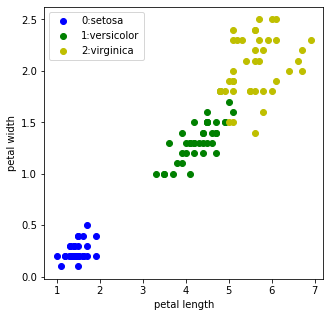

In [2]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("./data/knn/iris_reduced.csv") 
X = data.iloc[:,:2]
y = data.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

plt.figure(figsize=(5,5))
plt.plot(X_train.loc[y_train==0].iloc[:,0], X_train.loc[y_train==0].iloc[:,1], "bo", label="0:setosa" )
plt.plot(X_train.loc[y_train==1].iloc[:,0], X_train.loc[y_train==1].iloc[:,1], "go", label="1:versicolor" )
plt.plot(X_train.loc[y_train==2].iloc[:,0], X_train.loc[y_train==2].iloc[:,1], "yo", label="2:virginica" )
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend()
plt.show()

The hyperparameter `p` of `KNeighborsClassifier` refers to the order of the Minkowski distance. Thus, `p=2` indicates the Euclidean distance. 

In [3]:
# Initialize KNeighborsClassifier with k=5, and perform predictions
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5, p=2)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

No model is learned by KNN, so no significant model output can be explored. For a test (or training) point, we can query its neighborhood for the given $k$. Let's find the k-nearest-neighbors of the first two test points: 

In [4]:
knn_clf.kneighbors(X_test[:2])

(array([[0.2236068 , 0.2236068 , 0.3       , 0.42426407, 0.4472136 ],
        [0.        , 0.1       , 0.1       , 0.1       , 0.1       ]]),
 array([[ 58, 112,  96, 108,  39],
        [107,  19,  67,  56,  29]], dtype=int32))

We can also obtain the predicted probabilities of each class. For the first two test points: 

In [5]:
knn_clf.predict_proba(X_test[:2])

array([[0., 0., 1.],
       [1., 0., 0.]])

In turn, this means that the classed predicted by KNN are:

In [6]:
knn_clf.predict(X_test[:2])

array([2, 0], dtype=int64)

The accuracy on the test set of KNN with k=5 is: 

In [7]:
knn_clf.score(X_test, y_test)

0.9666666666666667

Which is as good as the one of Decision trees. (Question: what is the implicit assumption made by KNN that seems to hold for the Iris data that makes it perform so well?). We conclude by plotting the decision boundaries: 

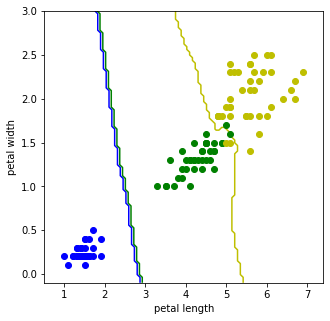

In [8]:
xx1, xx2 = np.meshgrid(np.linspace(X.iloc[:,0].min()-0.5, X.iloc[:,0].max()+0.5, 100),
                       np.linspace(X.iloc[:,1].min()-0.2, X.iloc[:,1].max()+0.5, 100))
zz = knn_clf.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)

plt.figure(figsize=(5,5))
plt.plot(X_train.loc[y_train==0].iloc[:,0], X_train.loc[y_train==0].iloc[:,1], "bo", label="0:setosa" )
plt.plot(X_train.loc[y_train==1].iloc[:,0], X_train.loc[y_train==1].iloc[:,1], "go", label="1:versicolor" )
plt.plot(X_train.loc[y_train==2].iloc[:,0], X_train.loc[y_train==2].iloc[:,1], "yo", label="2:virginica" )
plt.contour(xx1, xx2, zz, levels=2, colors=['b', 'g', 'y'])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.show()

Despite the similar performance to Decision Trees, the decision boundaries of KNN are completely different! (Compare them with the notebook on Decision Trees). As an *exercise*, manipulate the values of $k$ and the order of the Minkowski distance $p$, to check how the boundaries and performance vary on this dataset. 

### 7.2 Regression
KNN for regression is in the function [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). We will use the *regression demo* data, where the test data will be predicted with *k=10* and Manatthan distance (Minkowski with $p=1$). 

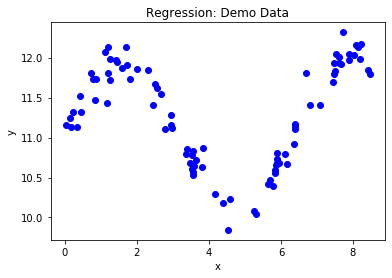

In [9]:
data = pd.read_csv("./data/decision_trees/demo_regression.csv")
x = data['x']
y = data['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

plt.figure(figsize=(6,4))
plt.plot(x_train, y_train, "bo")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression: Demo Data")
plt.show()

In [10]:
from sklearn.neighbors import KNeighborsRegressor
x_train_np = x_train.to_numpy().reshape(-1,1)
x_test_np = x_test.to_numpy().reshape(-1,1)

knn_reg = KNeighborsRegressor(n_neighbors=5, p=1)    # K nearest neighbors with Manatthan distance
knn_reg.fit(x_train_np, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='uniform')

The neighbors of the first test point is: 

In [11]:
knn_reg.kneighbors(x_test_np[0].reshape(1,-1))

(array([[0.01414736, 0.03868186, 0.35784086, 0.41456021, 0.48568841]]),
 array([[61, 55, 20, 33, 36]], dtype=int32))

Predictions for the first five test points are:

In [12]:
knn_reg.predict(x_test_np[:5])

array([10.27765785, 11.76013216, 10.07538499, 10.27765785, 10.07538499])

The $R^2$ value for the test set is:

In [13]:
knn_reg.score(x_test_np, y_test)

0.9030030983343892

We can see the predictions across the range of the training points graphically: 

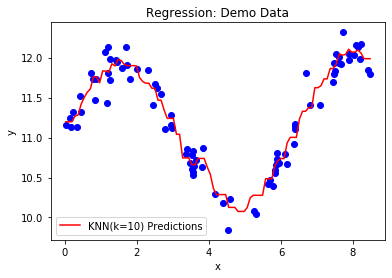

In [14]:
x_range = np.linspace(x_train_np.min(), x_train_np.max(), 100)
reg_pred = knn_reg.predict(x_range.reshape(-1,1))

plt.figure(figsize=(6,4))
plt.plot(x_train, y_train, "bo")
plt.plot(x_range, reg_pred, "r-", label="KNN(k=10) Predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression: Demo Data")
plt.legend(loc=3)
plt.show()

As usual, try out different setting for the KNN regressor (by varying k and the order of the Minkowski distance), and compare results.

**Note**. The type of algorithm used to find the nearest neighbors (brute-force, KD-tree, ball-tree), can be modified with the `algorithm` hyperparameter. Furthermore, scikit-learn also provides a `weights` hyperparameter, which allows weighing each neighbor for the final predictions. For instance, it is possible to give more weight to closer neighbors. See the functions documentation for further information. 

## 8. Example on the Heart Data
We now test KNN with the Heart Dataset. We will use 10-fold-cross validation for model selection. In this case, we will vary the number of neighbors $k$; we will use the KD-tree algorithm for neighbors search, and the Manatthan distance. As an exercise, try to grid-search across different values of `k` (number of neighbors) and `p` (Minkovski distance order) simultaneously, and check the new results. 

In [15]:
# 1. Load datasets
data_train = pd.read_csv("./data/heart_data/heart_train_processed.csv")
data_test = pd.read_csv("./data/heart_data/heart_test_processed.csv")
X_train = data_train.drop("y", axis=1)
X_test = data_test.drop("y", axis=1)
y_train = data_train["y"]
y_test = data_test["y"]

In [16]:
# Prepare the grid and tune with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Set parameter grid 
k_grid = [1, 2, 5, 8, 10, 12, 15, 20, 25, 30, 40, 50, 75, 90, 100, 110, 120, 150]
tuning_parameters = [{'n_neighbors': k_grid}]

# Launch GridSearchCV
clf = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree', p=1), tuning_parameters, cv=10, n_jobs=-1, verbose=2 )
clf.fit(X_train, y_train)
print("CV Grid Search: Done")

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.8s


CV Grid Search: Done


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    6.3s finished


In [17]:
clf.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=1,
                     weights='uniform')

The best number of neighbors found by GridSearchCV was $k=15$. Let's plot the values of $k$ against the CV accuracy:

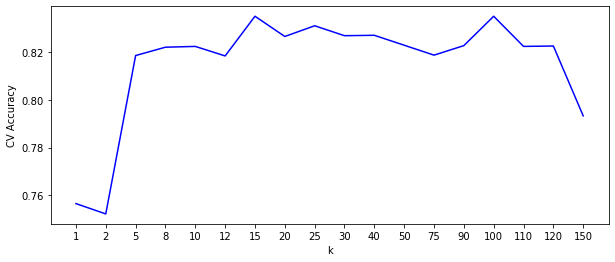

In [18]:
cv_res = pd.DataFrame(clf.cv_results_).sort_values(by="param_n_neighbors")
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(1, len(k_grid), len(k_grid)), 
         cv_res["mean_test_score"], "b-", label="CV Scores")
plt.xlabel("k")
plt.ylabel("CV Accuracy")
plt.xticks(np.linspace(1, len(k_grid), len(k_grid)), k_grid)
plt.show()

Another model with accuracy similar to the one of KNN with $k=15$ seems to be KNN with $k=100$. Let's compare the two scores:

In [19]:
# k=15: 
clf.best_score_

0.8351666666666666

In [20]:
# k=100: 
cv_res[cv_res.param_n_neighbors==100]["mean_test_score"]

14    0.835167
Name: mean_test_score, dtype: float64

The two accuracies are actually the same. We decide anyway to continue with $k=15$. The final accuracy on the test set is:   

In [21]:
clf.best_estimator_.score(X_test, y_test)

0.8032786885245902

Thus, the best KNN found by Cross-Validation seem to perform worse than linear models, but better than Decision Trees on the Heart Dataset. 